Serail Bias

In [258]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/aiswarya/miniconda3/envs/Ntorchmodel/bin/python


<Figure size 600x370.82 with 0 Axes>

In [259]:
import sys
sys.path.insert(0, '../')

import torch
import gc
import pandas as pd
import numpy as np
from time import perf_counter

from src.network import Network
from src.decode import decode_bump
from src.utils import clear_cache

In [260]:
def convert_seconds(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return h, m, s

In [261]:
REPO_ROOT = '/home/aiswarya/Model2/NeuroFlame/'
conf_name = 'config_ringEI.yml'

Doing a Parameter Search over Jee and Je0

Steps 
1. Generate Model
2. Create the list of parameters
3. Creating New tensors to incorporate the generated list of parameters



In [262]:
model = Network(conf_name, REPO_ROOT, IF_STP=1, VERBOSE=0, LIVE_FF_UPDATE=1, N_BATCH=1)

In [263]:
N_JEE = 20
N_JE0 = 10

JEE_list = torch.linspace(5, 10, N_JEE, device='cuda')
print('Jee list', JEE_list)
JE0_list = torch.linspace(0, 10, N_JE0, device='cuda')
print('Je0 list', JE0_list)

Jee list tensor([ 5.0000,  5.2632,  5.5263,  5.7895,  6.0526,  6.3158,  6.5789,  6.8421,
         7.1053,  7.3684,  7.6316,  7.8947,  8.1579,  8.4211,  8.6842,  8.9474,
         9.2105,  9.4737,  9.7368, 10.0000], device='cuda:0')
Je0 list tensor([ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
         8.8889, 10.0000], device='cuda:0')


Creating two new tensors J<sub>EE</sub> and J<sub>E0</sub> of size (N<sub>JEE</sub>, N<sub>JE0</sub>)
where each row of J<sub>EE</sub> is a repetition of Jee list and each column of Je0 is a copy of Je0 list.
In that way, all the values of J<sub>EE</sub> are associated once with a value of Je0.


In [264]:
JEE = JEE_list.unsqueeze(0).expand(N_JE0, N_JEE)
print('JEE first col', JEE[:, 0])

JE0 = JE0_list.unsqueeze(1).expand(N_JE0, N_JEE)
print('JE0 first row', JE0[0])

JEE first col tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.], device='cuda:0')
JE0 first row tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


In [265]:
JEE = JEE.reshape((-1, 1)) 
print('JEE', JEE.shape)

JE0 = JE0.reshape((-1, 1)) * model.M0  # Here M0 is a scaling factor that we have to add
print('JE0', JE0.shape)

JEE torch.Size([200, 1])
JE0 torch.Size([200, 1])


In [266]:
N_BATCH = N_JE0 * N_JEE
# Here we need to do some work on Ja0 first,
# since it has two dimensions for E and I and we need to repeat the I values
Ja0 = model.Ja0.repeat((N_BATCH, 1, 1))
print('Ja0', Ja0.shape)

# now we can pass JE0 to Ja0
Ja0[:,0] = JE0

# and pass N_BATCH, Ja0 and Jee to the model
model.N_BATCH = N_BATCH
# copy Ja0
model.Ja0 = Ja0
# in the model with stp, JEE is J_STP
model.J_STP = JEE

Ja0 torch.Size([200, 2, 1])


In [267]:
start = perf_counter()
rates = model().cpu().detach().numpy()
end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))
print('rates', rates.shape)

Elapsed (with compilation) = 0h 0m 11s
rates (200, 21, 500)


In [268]:
m0, m1, phi = decode_bump(rates, axis=-1)

m0 = m0.reshape(N_JE0, N_JEE, -1)
m1 = m1.reshape(N_JE0, N_JEE, -1)

In [269]:
JEE = np.linspace(5, 10, N_JEE)
JE0 = np.linspace(0, 10, N_JE0)

Text(0, 0.5, '$J_{E0}$')

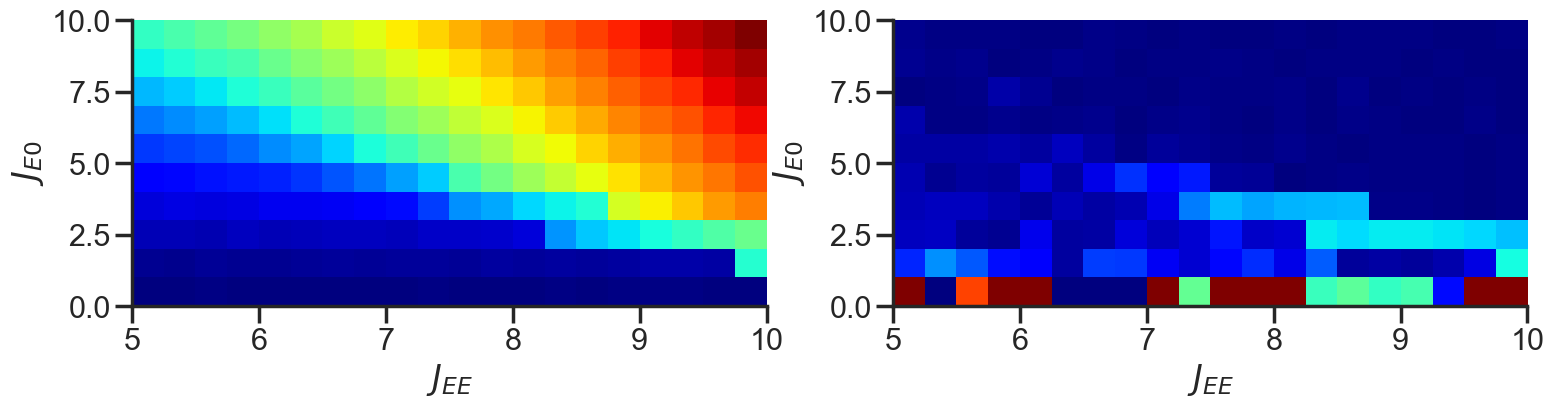

In [270]:
fig, ax = plt.subplots(1, 2, figsize=[3*width, height])

ax[0].imshow(m0[..., -1], cmap='jet', origin='lower', vmin=0, aspect='auto', extent=[JEE[0], JEE[-1], JE0[0], JE0[-1]])
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$J_{E0}$')

ax[1].imshow(m1[...,-1]/m0[...,-1], cmap='jet', origin='lower', vmin=0, vmax=3, aspect='auto', extent=[JEE[0], JEE[-1], JE0[0], JE0[-1]])
ax[1].set_xlabel('$J_{EE}$')
ax[1].set_ylabel('$J_{E0}$')


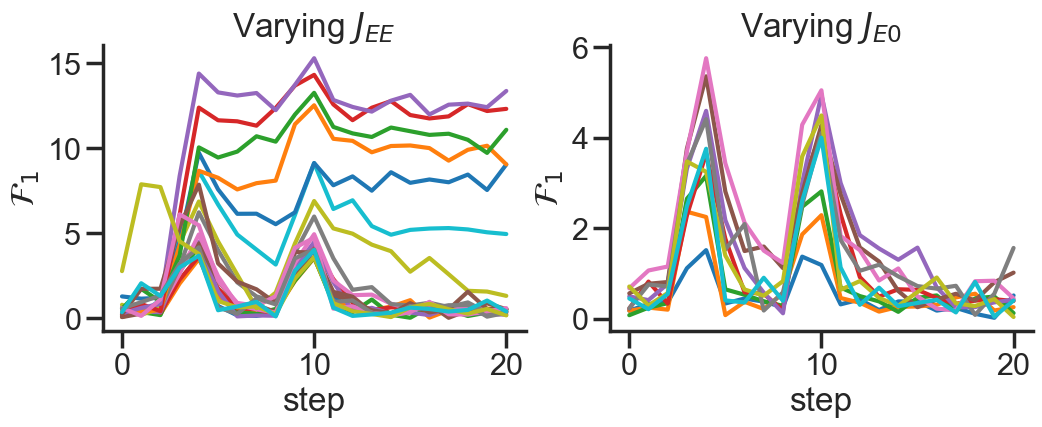

In [271]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].plot(m1[3].T)
ax[0].set_ylabel('$\mathcal{F}_1$')
ax[0].set_xlabel('step')
ax[0].set_title('Varying $J_{EE}$')

ax[1].plot(m1[:, 3].T)
ax[1].set_ylabel('$\mathcal{F}_1$')
ax[1].set_xlabel('step')
ax[1].set_title('Varying $J_{E0}$')

plt.show()

The parameters corresponding to (row 3, col -1) work

We can get their values from the original list


In [272]:
JE0 = torch.linspace(0, 10, N_JE0, device='cuda')
print('JE0', JE0[3].item())

JEE = torch.linspace(5, 10, N_JEE, device='cuda')
print('JEE', JEE[-1].item())

JE0 3.3333334922790527
JEE 10.0


In [281]:
model = Network(conf_name, REPO_ROOT, TASK='odr',
                VERBOSE=0, DEVICE='cuda', seed=0, N_BATCH=1, LIVE_FF_UPDATE=1)

model.Ja0[:, 0] = JE0[3] 
model.J_STP = JEE[-1]

In [282]:
rates = model().cpu().numpy()

In [283]:
m0, m1, phi = decode_bump(rates, axis=-1)
print('m0', m0.shape)

m0 (1, 21)


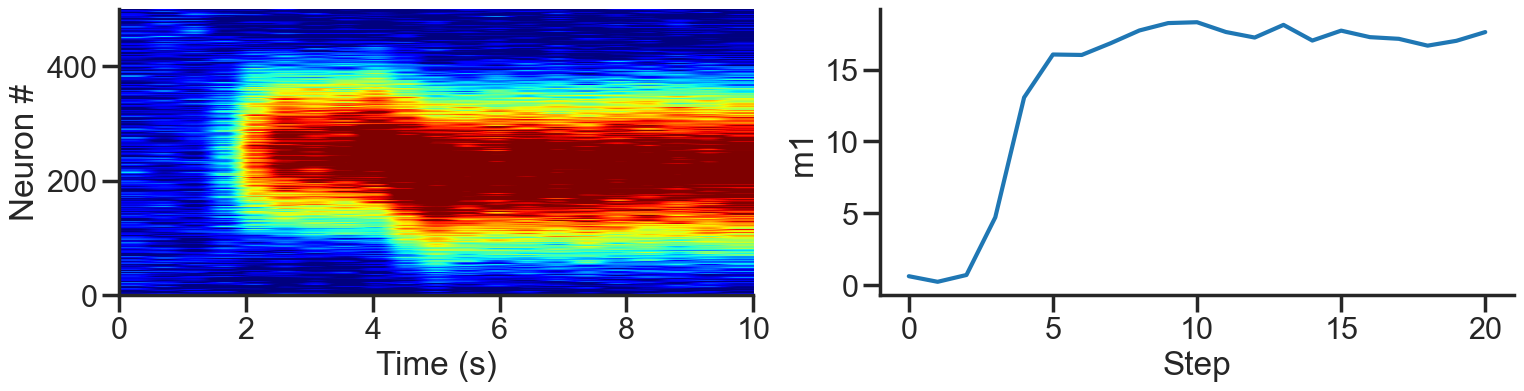

In [284]:
fig, ax = plt.subplots(1, 2, figsize=(3*width, height))

r_max = 30

ax[0].imshow(rates[0].T, aspect='auto', 
             cmap='jet', vmin=0, vmax=r_max, 
             origin='lower', extent=[0, model.DURATION, 0, model.N_NEURON  * model.frac[0]])
ax[0].set_ylabel('Neuron #')
ax[0].set_xlabel('Time (s)')

ax[1].plot(m1.T)
ax[1].set_ylabel('m1')
ax[1].set_xlabel('Step')

plt.show()

checking for Serial Bias
1.error = final position - target position
2.plot error vs target position.
3. Input batch 
